# Building the Space Ownership Model and Prediction Pipeline

In [268]:
# Loading relevant packages 

from tensorflow.keras.models import load_model
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import itertools
import numpy as np
from tqdm import tqdm
from pyathena import connect
conn = connect(s3_staging_dir='s3//:nyg-hackathon-811331780957/ohsaquonuc/',
               work_group = 'ohsaquonuc',
               region_name = 'us-east-1')

#### Loading up Space Ownership model from previous research

In [243]:
model = load_model('time_model.h5')

#### Defining useful functions for simulations and prediction pipeline

In [304]:
def distance(x1, x2, y1, y2):
    return (((x2-x1)**2)+((y2-y1)**2))**.5

def deg_to_rad(x1, x2, y1, y2, deg):
    initial_angle = (deg*math.pi)/180
    diff_x = x2 - x1
    diff_y = y2 - y1
    return math.atan2(math.cos(initial_angle)*diff_y - diff_x * math.sin(initial_angle),
                      diff_x*math.cos(initial_angle)+diff_y*math.sin(initial_angle))

def deg_to_negative(x):
        if x.all() == 180:
            return 0
        elif x.all() < 180:
            return x-180
        elif x.all() > 180:
            return x-180
        
        
# Pipeline Functions #
        
def ready_columns(dataframe):
    dataframe_cols = list(dataframe.columns)
    dataframe_cols.remove('position')
    dataframe_cols.remove('firstname')
    dataframe_cols.remove('lastname')
    dataframe_cols.remove('offense_or_defense')
    for i in dataframe_cols:
        dataframe[i] = pd.to_numeric(dataframe[i])      
    return dataframe

def expandgrid(*itrs):
    product = list(itertools.product(*itrs))
    return {'Var{}'.format(i+1):[x[i] for x in product] for i in range(len(itrs))}

def expanded_grid(df1):
    df1['key'] = 1
    df2 = pd.DataFrame(expandgrid(np.arange(0,101,1), np.arange(0,55,1)))
    df2['key'] = 1  
    df3 = pd.merge(df1,df2,on='key').drop('key',axis=1)
    df3 = df3.rename(columns={'Var1' : 'free_x', 'Var2' : 'free_y'})
    return df3

def create_inputs(df1):
    df1['distance'] = 0
    for i in range(len(df1)):
        df1['distance'][i] = distance(df1['player_x'][i], df1['free_x'][i], df1['player_y'][i], df1['free_y'][i])
    df1['angle_in_radians'] = 0
    for i in range(len(df1)):
        df1['angle_in_radians'][i] = deg_to_rad(df1['player_x'][i], df1['free_y'][i], df1['player_y'][i], df1['free_y'][i], df1['player_direction_in_degrees'][i])
    return df1

def pred(df1, model_name):
    nn_model = load_model(model_name)
    df_x = df1[['player_directional_acceleration', 'weight', 'height', 'distance', 'angle_in_radians']]
    df_x_ss = x_ss.transform(df_x)
    df1['time'] = nn_model.predict(df_x_ss)
    return df1
    
def extract_probs(df1):
    probs = {}

    for x in np.arange(0,101,1):
        probs[f'{x}'] = []

    for x in np.arange(0,101,1):
            for y in np.arange(0,55,1):
                free_xy_frame = df1[(df1['free_x']==x) & (df1['free_y']==y)]
                smallest_times = free_xy_frame.nsmallest(n=10, columns='time')            
                probs[f'{x}'].append(smallest_times['offense_or_defense'].sum()/10)
    probs_frame = pd.DataFrame(probs)
    return probs_frame

def extract_owner(df1):
    probs = {}

    for x in np.arange(0,101,1):
        probs[f'{x}'] = []

    for x in np.arange(0,101,1):
            for y in np.arange(0,55,1):
                free_xy_frame = df1[(df1['free_x']==x) & (df1['free_y']==y)]
                smallest_times = free_xy_frame.nsmallest(n=1, columns='time')            
                probs[f'{x}'].append(smallest_times['offense_or_defense'].sum()/1)
    probs_frame = pd.DataFrame(probs)
    return probs_frame
    

def plot_ownership(df1, df5, ownership_type):

    y_maximums = [0, 0, 54, 54]
    x_maximums = [0, 100, 0, 100]

    fig=plt.figure(figsize=(16, 14))
    ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

    plt.plot([x_maximums[0], x_maximums[2]], [y_maximums[0], y_maximums[2]], 'r')
    plt.plot([x_maximums[1], x_maximums[3]], [y_maximums[1], y_maximums[3]], 'r')
    plt.plot([x_maximums[0]-10, x_maximums[2]-10], [y_maximums[0], y_maximums[2]], 'w')
    plt.plot([x_maximums[1]+10, x_maximums[3]+10], [y_maximums[1], y_maximums[3]], 'w')
    plt.plot([x_maximums[0]-10, x_maximums[1]+10], [y_maximums[0], y_maximums[1]], 'w')
    plt.plot([x_maximums[2]-10, x_maximums[3]+10], [y_maximums[2], y_maximums[3]], 'w')

    for i in range(1,10):
        plt.plot([x_maximums[0]+i*10, x_maximums[2]+i*10], [y_maximums[0], y_maximums[2]], 'w--')

    for i in range(len(df1)):
        if step1['offense_or_defense'][i] == 1:
            plt.plot(df1['player_x'][i], df1['player_y'][i], 'bo') 
        else:
            plt.plot(df1['player_x'][i], df1['player_y'][i], 'ro')

    if ownership_type == 'absolute':
        # Plot Ownership        
        for i in np.arange(0,101,1):
            for j in np.arange(0,54,1):
                if df5[f'{i}'][j] == 0.0:
                    plt.plot(i, j, 'ys', alpha=.5)

    else:   
        # Plot Ownership using Probabilities            
        for i in np.arange(0,101,1):
            for j in np.arange(0,54,1):
                if df5[f'{i}'][j] < .5:
                    plt.plot(i, j, 'ys', alpha=.5)
                if df5[f'{i}'][j] == .5:
                    plt.plot(i, j, 'ks', alpha=.25)



    plt.title('Players on the Field')
    plt.yticks(np.arange(0, 55, step=5), np.arange(0,55, step=5))
    plt.xticks(np.arange(0, 101, step=10), np.append(np.arange(0, 51, 10),(np.arange(-40, 1, step=10)**2)**.5))
    plt.ylim(0,55)
    plt.xlim(0,101)
    plt.axis('scaled')
    ax.set_facecolor('xkcd:green')


    plt.show()    









#### Reading in a sample of data to begin simulations

In [245]:
df = pd.read_sql("""select firstname, lastname, position, player_x, player_y, player_speed, player_direction_in_degrees, player_directional_acceleration, weight, height from ohsaquonuc.all_tracking_data TABLESAMPLE BERNOULLI (0.3);""", conn)

#### Manipulating the sample of data and simulating space ownership using previously referenced Space Ownership model

In [247]:
df['random_x'] = 0
df['random_y'] = 0

for x in tqdm(range(len(df))):
    df['random_x'][x] = random.randint(0,101)
    df['random_y'][x] = random.randint(0,55)

  0%|          | 0/1417860 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 1417860/1417860 [02:59<00:00, 7892.07it/s]


In [252]:
df_cols = list(df.columns)
df_cols.remove('position')
df_cols.remove('firstname')
df_cols.remove('lastname')
for i in df_cols:
    df[i] = pd.to_numeric(df[i])
    
df['distance'] = distance(df['player_x'], df['random_x'], df['player_y'], df['random_y'])

df['angle_in_radians'] = 0

for i in tqdm(range(len(df))):
    df['angle_in_radians'][i] = deg_to_rad(df['player_x'][i], df['random_x'][i], df['player_y'][i], df['random_y'][i], df['player_direction_in_degrees'][i])

  0%|          | 0/1417860 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 1417860/1417860 [04:31<00:00, 5215.66it/s]


In [253]:
df.head()

,firstname,lastname,position,player_x,player_y,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height,random_x,random_y,distance,angle_in_radians
0,Linval,Joseph,DT,75.20,23.86,0.02,330.67,0.20,329.000000,76.000000,87,48,26.869678,1
1,Christopher,Jones,DT,75.42,22.12,0.02,1.49,0.02,309.722271,75.018037,12,33,64.346490,2
2,Tim,McDonald,SS,84.42,28.67,1.42,273.71,0.38,207.599873,72.127077,75,19,13.499826,0
3,Tim,McDonald,SS,15.02,29.90,1.49,244.67,0.12,207.599873,72.127077,76,22,61.489596,1
4,Jordan,Phillips,DT,23.89,27.07,0.37,103.19,0.18,341.000000,78.000000,63,22,39.437254,-1


In [254]:
new_data = df[['distance', 'player_speed', 'angle_in_radians']]
new_data = new_data.rename(columns={'player_speed':'speed', 'angle_in_radians':'angle'})
new_data.head()


,distance,speed,angle
0,26.869678,0.02,1
1,64.346490,0.02,2
2,13.499826,1.42,0
3,61.489596,1.49,1
4,39.437254,0.37,-1


In [255]:
df['time'] = model.predict(new_data)

In [256]:
df.head()

,firstname,lastname,position,player_x,player_y,player_speed,player_direction_in_degrees,player_directional_acceleration,weight,height,random_x,random_y,distance,angle_in_radians,time
0,Linval,Joseph,DT,75.20,23.86,0.02,330.67,0.20,329.000000,76.000000,87,48,26.869678,1,3.536839
1,Christopher,Jones,DT,75.42,22.12,0.02,1.49,0.02,309.722271,75.018037,12,33,64.346490,2,7.658607
2,Tim,McDonald,SS,84.42,28.67,1.42,273.71,0.38,207.599873,72.127077,75,19,13.499826,0,1.948640
3,Tim,McDonald,SS,15.02,29.90,1.49,244.67,0.12,207.599873,72.127077,76,22,61.489596,1,7.411058
4,Jordan,Phillips,DT,23.89,27.07,0.37,103.19,0.18,341.000000,78.000000,63,22,39.437254,-1,4.923162


#### Using the simulated data to train a new Space Ownership Neural Network

In [ ]:
# New Model #

In [259]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [260]:
df_x = df[['player_directional_acceleration', 'weight', 'height', 'distance', 'angle_in_radians']]
df_y = df[['time']]

train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=0.33, random_state=3)

x_ss = StandardScaler(with_mean=True)
y_ss = StandardScaler(with_mean=True)
train_x = x_ss.fit_transform(train_x)
train_y = y_ss.fit_transform(train_y)
test_x = x_ss.transform(test_x)
test_y = y_ss.transform(test_y)

In [261]:
# Neural Network #

model = Sequential()
model.add(Dense(64, input_dim = 5, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse', 'mae'])

cp = ModelCheckpoint(filepath="space_owner_final.h5", save_best_only=True, verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = model.fit(train_x, train_y,
                    epochs=50,
                    batch_size=120,
                    shuffle=True,
                    validation_data=(test_x, test_y),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 949966 samples, validate on 467894 samples
Epoch 1/50
949966/949966 [==============================] - 25s 26us/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0478 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0429
Epoch 2/50
949966/949966 [==============================] - 23s 24us/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0401 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0386
Epoch 3/50
949966/949966 [==============================] - 23s 24us/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0391 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0390
Epoch 4/50
949966/949966 [==============================] - 23s 24us/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0388 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0413
Epoch 5/50
9

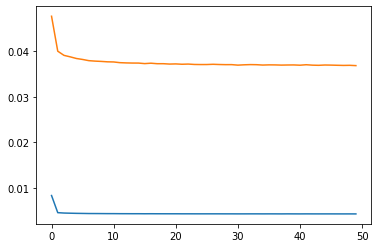

In [262]:
# Plotting the errors of the models training sessions

plt.plot(history['mean_squared_error'])
plt.plot(history['mean_absolute_error'])
plt.show()